# Fingerphotos recognition

Fingerprint recognition is probably the most mature biometric technique, which finds lots of real - life applications since long ago.
This notebook is for Authentication / Verification with fingerphotos. 

## Data
IIITD SmartPhone Fingerphoto Database v1 ([ISPFDv1](http://iab-rubric.org/resources/spfd.html)) consists of fingerphotos and live scan images captured using Lumidgm Sensor. It has data for 64 subjects, collected for both right index and right middle finger, hence making a total of 128 classes. This database covers illumination and background variation challenges.

In [1]:
import cv2
import numpy as np
import math 
import operator
from skimage.measure import label  
from skimage.morphology import skeletonize, thin
from skimage import  morphology, filters
from skimage.util import invert
from matplotlib import pyplot as plt

from utils import *
from constants import *
from preprocessing import *
from plots import *
import glob

from sklearn.metrics import accuracy_score, precision_score, f1_score

# pyeer library: pip install pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

In [2]:
#load filename
image_files = read_images()
print(len(image_files))

24


In [3]:
# convert bgr to rgb
def convert_bgr2rgb(filename):
    img_fpr = cv2.imread(filename)
    image = cv2.cvtColor(img_fpr, cv2.COLOR_BGR2RGB)
    pixels = np.array(image)
    return pixels

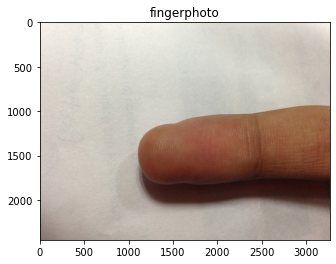

In [4]:
curr_img =20
# display first load image
plt.subplot(1,1, 1)
plt.title('fingerphoto')
plt.imshow(convert_bgr2rgb(image_files[curr_img]))
plt.show()

### Segmentation

- skin detection with M channel of CMYK color space
- extract the Region of Interest (ROI)

In [5]:
#1- Skin detection

#1.1- convert BGR to CMYK and extract the M channel
# CMYK stands for Cyan, Magenta, Yellow and Key (Black)
# Import image
img = cv2.imread(image_files[curr_img])
# Create float
bgr = img.astype(float)/255.

# Extract channels
with np.errstate(invalid='ignore', divide='ignore'):
	K = 1 - np.max(bgr, axis=2)
	C = (1-bgr[...,2] - K)/(1-K)
	M = (1-bgr[...,1] - K)/(1-K)
	Y = (1-bgr[...,0] - K)/(1-K)

# Convert the input BGR image to CMYK colorspace
CMYK = (np.dstack((C,M,Y,K)) * 255).astype(np.uint8)

# Split CMYK channels
Y, M, C, K = cv2.split(CMYK)

np.isfinite(C).all()
np.isfinite(M).all()
np.isfinite(K).all()
np.isfinite(Y).all()


#1.2- Apply adaptative treshold and get binary mask
(thresh, im_bw) = cv2.threshold(M, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#print("Obtained threshold: ", thresh)
#print(np.unique(im_bw))

# display M channekl and mask
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)

#ax = axes.ravel()

#ax[0].imshow(M, cmap=plt.cm.gray)
#ax[0].axis('off')
#ax[0].set_title('CMYK, M channel', fontsize=20)

#ax[1].imshow(im_bw, cmap=plt.cm.gray)
#ax[1].axis('off')
#ax[1].set_title('thresh Otsu Mask', fontsize=20)

#fig.tight_layout()
#plt.show()

In [6]:

# 1.3- remove the false positive errors, 
#the largest connected component is found using the
#standard run-length encoding technique

before_img=im_bw
labels = label(im_bw, return_num=False)

maxCC_withbcg = labels == np.argmax(np.bincount(labels.flat))
maxCC_nobcg = labels == np.argmax(np.bincount(labels.flat, weights=im_bw.flat))

im_bw= maxCC_nobcg.astype(np.uint8)


# display M channekl and mask
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)

#ax = axes.ravel()

#ax[0].imshow(before_img, cmap=plt.cm.gray)
#ax[0].axis('off')
#ax[0].set_title('thresh otsu mask', fontsize=20)

#ax[1].imshow(im_bw, cmap=plt.cm.gray)
#ax[1].axis('off')
#ax[1].set_title('get largest connected', fontsize=20)

#fig.tight_layout()
#plt.show()

In [7]:
#1.4- remove the false negative errors, 
# image opening operation is performed (erode and dilate)
# twice with a square structuring element
# Taking a matrix of size 5 as the kernel


#kernel = np.ones((11,11), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
 
# The first parameter is the original image,
# kernel is the matrix with which image is
# convolved and third parameter is the number
# of iterations, which will determine how much
# you want to erode/dilate a given image.

# erosion (erode)
# It is useful for removing small white noises
# Used to detach two connected objects etc

img_erosion = cv2.erode(im_bw, kernel, iterations=2)


# dilation
#In cases like noise removal, erosion is followed by dilation. Because, erosion removes white noises, 
#but it also shrinks our object. 
# So we dilate it. Since noise is gone, they won’t come back, but our object area increases
# It is also useful in joining broken parts of an object
img_dilation = cv2.dilate(img_erosion, kernel, iterations=2)

im_bw = img_dilation

# display M channekl and mask
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),sharex=True, sharey=True)

#ax = axes.ravel()

#ax[0].imshow(img_erosion, cmap=plt.cm.gray)
#ax[0].axis('off')
#ax[0].set_title('after erosion', fontsize=20)

#ax[1].imshow(im_bw, cmap=plt.cm.gray)
#ax[1].axis('off')
#ax[1].set_title('after dilatation', fontsize=20)

#fig.tight_layout()
#plt.show()


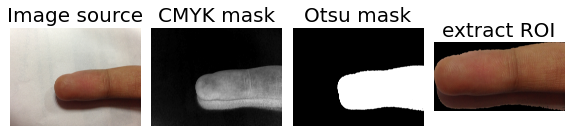

In [8]:

#2- extract ROI
#(thresh, im_bw) = cv2.threshold(I, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
(thresh, im_bw) = cv2.threshold(im_bw, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#print("Obtained threshold: ", thresh)
points = np.argwhere(im_bw>thresh) # find where the black pixels are
points = np.fliplr(points) # store them in x,y coordinates instead of row,col indices
x, y, w, h = cv2.boundingRect(points) # create a rectangle around those points
im_bw_crop = im_bw[y:y+h, x:x+w] # create a cropped region of the gray image
img_crop = img[y:y+h, x:x+w] # create a cropped region of the gray image





# convert to 3 channel
#norm = cv2.cvtColor(norm, cv2.COLOR_GRAY2BGR)
#print(im_bw_crop.shape, im_bw_crop.dtype)
#print(img_crop.shape, img_crop.dtype)


img_segmented = cv2.bitwise_and(img_crop,img_crop,mask= im_bw_crop)
# Color background white
#result[mask==0] = 255 # Optional


# display M channekl and mask
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 4))

ax = axes.ravel()

ax[0].imshow(convert_bgr2rgb(image_files[curr_img]), cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Image source', fontsize=20)

ax[1].imshow(M, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('CMYK mask', fontsize=20)

ax[2].imshow(im_bw, cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('Otsu mask', fontsize=20)

ax[3].imshow(cv2.cvtColor(img_segmented, cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
ax[3].axis('off')
ax[3].set_title('extract ROI', fontsize=20)
fig.tight_layout()
plt.show()


### Fingerphoto enhancement
- normalize the effect of illumination variation and blurriness (GassianBlur)
- improve the contrast between ridge and valley structure (equalizeHist)
- reduce ridges to one pixel
    - a lightweight representation of the fingerprint is produced using Thinning(Skeletonization) 
    - applying the Zhang-Suen algorithm

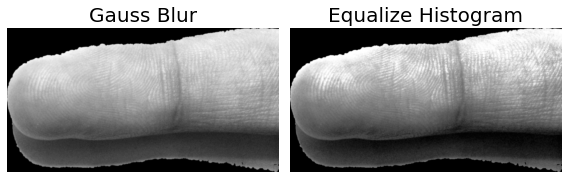

In [9]:
#1- normalize the effect of illumination variation and blurriness
# Segmented image obtained from the previous step is converted to gray scale
img_segmented_gray = cv2.cvtColor(img_segmented,cv2.COLOR_BGR2GRAY)


# gaussion blur with sigma 2
# to preserve high frequency components (such as edges)
img_blur=cv2.GaussianBlur(img_segmented_gray,(11,11),0)

# ridges (darker curves) and valleys (brighter curves) differentiation using 
# contrast enhancements with equalizeHist
image_eq = cv2.equalizeHist(img_blur)




# display M channekl and mask
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ax = axes.ravel()

ax[0].imshow(img_blur, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Gauss Blur', fontsize=20)

ax[1].imshow(image_eq, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Equalize Histogram', fontsize=20)
fig.tight_layout()
plt.show()

In [10]:
#2- skeletization
float_image_eq= image_eq.astype("float32")
#print(np.unique(float_image_eq))

#step 1: get ridge segment by padding then do block process
blockSize = 24
threshold = 0.05


In [11]:
# Apply padding to the image.
# create a border around the image like a photo frame
height, width = float_image_eq.shape
bottomPadding = 0
rightPadding = 0

if (width % blockSize != 0) :
    bottomPadding = blockSize - (width % blockSize)
        
if (height % blockSize != 0) :
    rightPadding = blockSize - (height % blockSize)

# Using cv2.copyMakeBorder() method
float_image_eq = cv2.copyMakeBorder(float_image_eq, 0, bottomPadding, 0, rightPadding, cv2.BORDER_CONSTANT, None, value = 0)

# display first load image
plt.subplot(1,1, 1)
plt.title('float_image_eq')
plt.imshow(float_image_eq, cmap=plt.cm.gray)
plt.show()

In [12]:
# calculate ridge segment by doing block process for the given image using the given block size.
#print(float_image_eq.shape)
#np.zeros((height,width), np.uint8) for one channel

matRidgeSegment = np.zeros(float_image_eq.shape, np.float32)
matRidgeSegment[:]=0.0

segmentMask = np.zeros(float_image_eq.shape, np.uint8)
segmentMask[:]=0


imgRows, imgCols = float_image_eq.shape
height, width = float_image_eq.shape

widthSteps =int(width/ blockSize)
heightSteps = int(height/ blockSize)

# White color in BGR
color = (255, 255, 255)

windowMask  = np.zeros(float_image_eq.shape, np.uint8)

for y in range(1,heightSteps+1) :
    for  x in range(1,widthSteps+1) :
        roi_x,roi_y,roi_width, roi_height= ((blockSize) * (x - 1), (blockSize) * (y - 1), blockSize, blockSize)
        windowMask[:] = 0
        windowMask = cv2.rectangle(windowMask, (roi_x, roi_y), (roi_x + roi_width, roi_y + roi_height), color, -1, 8, 0)
        y1=roi_y
        y2=y1+roi_height
        x1=roi_x
        x2=x1+roi_width
        
        window = float_image_eq[y1:y2 , x1:x2]
        # display first load image
        mean, std = cv2.meanStdDev(window)
       # m_list.append(mean.reshape((3,)))
       # s_list.append(std.reshape((3,)))
       # m_array = np.array(m_list)
       # s_array = np.array(s_list)
       # m = m_array.mean(axis=0, keepdims=True)
       # s = s_array.mean(axis=0, keepdims=True)
        mean_val = mean[0][0]
        std_val = std[0][0]
        matRidgeSegment[windowMask>0] = std_val
        segmentMask[windowMask>0] = 1 if std_val >=threshold else 0
        
            
# get mean and standard deviation
mean, std = cv2.meanStdDev(float_image_eq, mask=segmentMask)

#fill_mean = np.zeros(matRidgeSegment.shape, np.float32)
#fill_mean[:]=mean[0][0]
#print('mean',fill_mean.shape,np.unique(fill_mean))

fill_mean=(mean[0][0],0,0,0)
float_image_eq=cv2.subtract(matRidgeSegment,fill_mean)
mean, std = cv2.meanStdDev(matRidgeSegment, mask=segmentMask)

#fill_std = np.zeros(matRidgeSegment.shape, np.float32)
#fill_std[:]=std[0][0]
#print('std',fill_std.shape,np.unique(fill_std))
fill_std=(std[0][0],0,0,0)
matRidgeSegment = cv2.divide(matRidgeSegment,fill_std)
        
print("ok")

ok


In [13]:
print('matRidgeSegment s: ',matRidgeSegment.shape)
print('segmentMask s:',segmentMask.shape)
print(np.unique(segmentMask))
print(np.unique(matRidgeSegment))


matRidgeSegment s:  (1143, 2169)
segmentMask s: (1143, 2169)
[0 1]
[0.0000000e+00 4.0452005e-03 4.9500205e-03 ... 7.8359032e+00 7.9600282e+00
 8.0153666e+00]


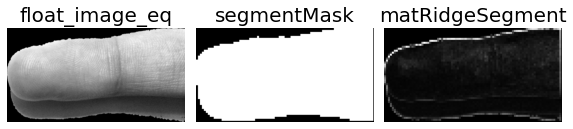

In [14]:
# display 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))

ax = axes.ravel()

ax[0].imshow(img_blur, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('float_image_eq', fontsize=20)

ax[1].imshow(segmentMask, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('segmentMask', fontsize=20)


ax[2].imshow(matRidgeSegment, cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('matRidgeSegment', fontsize=20)


fig.tight_layout()
plt.show()

In [15]:
def gaussianKernel(kSize, Sigma):
    kernelX = cv2.getGaussianKernel(kSize, Sigma)
    kernelY = cv2.getGaussianKernel(kSize, Sigma)

    kernel = np.ones((kSize, kSize), np.float32)
    #kernel= np.outer(kernelX, kernelY.transpose())
    #kernel=cv2.multiply(kernelX.transpose(), kernelY.transpose())
    fill_third= np.zeros((kSize, kSize), np.float32)
    fill_third[:]=0.0
    kernel= cv2.gemm(kernelX, kernelY.transpose(), 1,fill_third, 0, 0)
    #kernel=cv2.multiply(kernelX, np.transpose(kernelY))
    return kernel


In [16]:
#step 2: get ridge orientation

gradientSigma = 1
blockSigma = 13
orientSmoothSigma = 15

ridgeSegment=matRidgeSegment

matRidgeOrientation = np.zeros((imgRows, imgCols), np.float32)
matRidgeOrientation[:]=0.0

rows, cols = matRidgeSegment.shape

# calculate image gradients
kSize = round(6 * gradientSigma)
if (kSize % 2 == 0) :
    kSize=kSize+1


kernel=gaussianKernel(kSize, gradientSigma)

print('kernel', kernel.shape)

fXKernel = np.zeros((1,3), np.float32)
fYKernel =np.zeros((3,1), np.float32)
fXKernel[0, 0]=-1.0
fXKernel[0, 1]= 0.0
fXKernel[0, 2]= 1.0

fYKernel[0, 0]=-1.0
fYKernel[1, 0]= 0.0
fYKernel[2, 0]= 1.0


fX=cv2.filter2D(kernel,  -1, fXKernel)
fY=cv2.filter2D(kernel, -1, fYKernel)

print('fX', fX.shape)
print('fY', fY.shape)
print('matRidgeSegment', matRidgeSegment.shape)

gX=cv2.filter2D(matRidgeSegment,-1, fX)
gY=cv2.filter2D(matRidgeSegment,-1, fY)

print('gX', gX.shape)
print('gY', gY.shape)

gXX= cv2.multiply(gX, gX)
gXY= cv2.multiply(gX, gY)
gYY= cv2.multiply(gY, gY)

#smooth the covariance data to perform a weighted summation of the data.
kSize = round(6 * blockSigma)
if (kSize % 2 == 0) :
    kSize=kSize+1

#analytic solution of principal direction
kernel=gaussianKernel(kSize, blockSigma)
gXX= cv2.filter2D(gXX, -1,kernel)
gYY= cv2.filter2D(gYY, -1,kernel)
gXY= cv2.filter2D(gXY, -1,kernel)

#target_mat = np.zeros(gXY.shape, np.float32)
#target_mat[:]=2
target_mat=(2,0,0,0)
gXY=cv2.multiply(gXY, target_mat)



#analytic solution of principal direction
gXXMiusgYY= cv2.subtract(gXX, gYY)
gXXMiusgYYSquared= cv2.multiply(gXXMiusgYY, gXXMiusgYY)
gXYSquared= cv2.multiply(gXY, gXY)
denom= cv2.add(gXXMiusgYYSquared, gXYSquared)
denom = cv2.sqrt(denom)

#sine and cosine of doubled angles
#sin2Theta = np.zeros((rows, cols), np.float32)/1.
#cos2Theta =np.zeros((rows, cols), np.float32)/1.
sin2Theta= cv2.divide(gXY, denom)
cos2Theta= cv2.divide(gXXMiusgYY, denom)

print('sin2Theta', sin2Theta.shape)
print('cos2Theta', cos2Theta.shape)

#smooth orientations (sine and cosine)
#smoothed sine and cosine of doubled angles
kSize = round(6 * orientSmoothSigma)
if (kSize % 2 == 0) :
    kSize=kSize+1
    
kernel = gaussianKernel(kSize, orientSmoothSigma)
sin2Theta = cv2.filter2D(sin2Theta,-1,kernel)
cos2Theta = cv2.filter2D(cos2Theta, -1,kernel)

#calculate the result as the following, so the values of the matrix range [0, PI]
#orientim = atan2(sin2theta,cos2theta)/360;
#atan2(sin2Theta, cos2Theta, result);
src1=sin2Theta
src2= cos2Theta
height = src1.shape[0]
width = src2.shape[1]


for y  in range(0,height) :
    for x in  range(0,width):
        matRidgeOrientation[y, x]= cv2.fastAtan2(float(src1[y, x]), float(src2[y, x]))
            
#fill_pi = np.zeros(matRidgeOrientation.shape, np.float32)
#fill_pi[:]=math.pi / 360.0   
fill_pi=(math.pi / 360.0,0,0,0) 
matRidgeOrientation=cv2.multiply(matRidgeOrientation, fill_pi)

kernel (7, 7)
fX (7, 7)
fY (7, 7)
matRidgeSegment (1143, 2169)
gX (1143, 2169)
gY (1143, 2169)
sin2Theta (1143, 2169)
cos2Theta (1143, 2169)


In [17]:
print(np.unique(matRidgeOrientation))

[1.1756270e-08 2.1788328e-07 2.8443628e-07 ...           nan           nan
           nan]


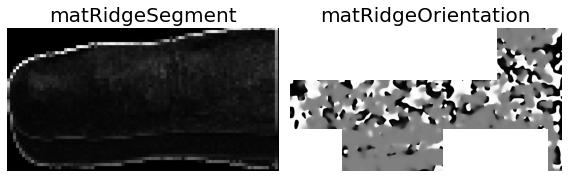

In [18]:
# display 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ax = axes.ravel()

ax[0].imshow(matRidgeSegment, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('matRidgeSegment', fontsize=20)

ax[1].imshow(matRidgeOrientation, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('matRidgeOrientation', fontsize=20)

fig.tight_layout()
plt.show()

In [19]:
def  calculateMean(m) :
    summ = 0
    for aM in m:
        summ += aM
        
    result =  summ / m.size
    
    return result
    


def medianFrequency(image):
    values = []
    rows,cols= image.shape
    for r  in range(0,rows):
        for c in range(0, cols):
            value = image[r, c]
            if (value > 0) :
                values.append(value)
                
    values.sort()
    size =len(values)
    median = 0

    if (size > 0) :
        halfSize = int(size / 2)
        if ((size % 2) == 0) :
            median = (values[halfSize - 1]+ values[halfSize]) / 2.0
        else:
            median = values[halfSize]

        
    return median
            
        
    
    
    
def calculateFrequency(block, blockOrientation, windowSize, minWaveLength, maxWaveLength):
    #print('block: ',block.shape,block.dtype)
    #print('block val: ',np.unique(block))
    
    rows,cols = block.shape
    orientation = blockOrientation.copy()
    orientation=cv2.multiply(orientation, (2.0,0,0,0))
    orientations= orientation.flatten()
    orientLength =orientations.shape[0]
    sinOrient = np.empty(shape=orientLength, dtype=np.float64)
    cosOrient = np.empty(shape=orientLength, dtype=np.float64)
    for i in range(1,orientLength):
        sinOrient[i] = math.sin(orientations[i])
        cosOrient[i] = math.cos(orientations[i])
    orient = cv2.fastAtan2(float(calculateMean(sinOrient)), float(calculateMean(cosOrient))) / float(2.0)

    #rotate the image block so that the ridges are vertical
    center = (cols / 2, rows / 2)
    rotateAngle = ((orient / math.pi) * (180.0)) + 90.0
    rotateScale = 1.0
    rotatedSize = (cols, rows)
    rotateMatrix = cv2.getRotationMatrix2D(center, rotateAngle, rotateScale)
    rotated= cv2.warpAffine(block, rotateMatrix, rotatedSize, flags = cv2.INTER_NEAREST)
    #print('rotated: ',rotated.shape,rotated.dtype)
    #print('rotated val: ',np.unique(rotated))

    # crop the image so that the rotated image does not contain any invalid regions
    # this prevents the projection down the columns from being mucked up
    cropSize = int(round(rows / math.sqrt(2)))
    offset = int(round((rows - cropSize) / 2.0) - 1)
    cropped = rotated[offset:offset + cropSize, offset:offset + cropSize]
    #print('cropped: ',cropped.shape,cropped.dtype)
    #print('cropped val: ',np.unique(cropped))
    

    #get sums of columns
    cropped_cols= cropped.shape[1]
    proj =   np.zeros((1,cropped_cols), np.float32)
    for c in range(1,cropped_cols):
        sum = 0
        for  r in range(1,cropped_cols):
            sum = sum + cropped[r, c]

        proj[0, c] = sum

    #find peaks in projected grey values by performing a grayScale
    # dilation and then finding where the dilation equals the original values.
    dilateKernel = np.zeros((windowSize, windowSize), np.float32)
    dilateKernel[:]=1.0
    dilate = np.zeros((1, cropped.shape[1]), np.float32)

    dilate= cv2.dilate(proj, dilateKernel,iterations = 1)
    #dilate=cv2.dilate(proj, dilateKernel, (-1, -1), 1, cv2.BORDER_CONSTANT, (0.0,0.0,0.0,0.0))

   # print('projr: ',proj.shape,proj.dtype)
   # print('proj val: ',np.unique(proj))
    
    projMean = cv2.mean(proj)[0]
 
    #print(projMean)

    ROUND_POINTS = 1000
    maxind = []
    for i in range(0,cropped.shape[1]) :

        projValue = proj[0, i]
        dilateValue = dilate[0, i]

        #round to maximize the likelihood of equality
        projValue = float(round(projValue * ROUND_POINTS) / ROUND_POINTS)
        dilateValue = float(round(dilateValue * ROUND_POINTS) / ROUND_POINTS)

        if (dilateValue == projValue and projValue > projMean) :
            maxind.append(i)

    #determine the spatial frequency of the ridges by dividing the distance between
    #the 1st and last peaks by the (No of peaks-1). If no peaks are detected
    #or the wavelength is outside the allowed bounds, the frequency image is set to 0
    result =  np.zeros((rows,cols), np.float32)
    result[:]=0.0
    peaks = len(maxind)
    if (peaks >= 2) :
        waveLength = (maxind[peaks - 1] - maxind[0]) / (peaks - 1)
        if (waveLength >= minWaveLength and waveLength <= maxWaveLength) :
            result =  np.zeros((rows,cols), np.float32)
            result[:]=1.0/ waveLength


    return result



In [20]:
# step 3: get ridge frequency
fBlockSize = 36
fWindowSize = 5
fMinWaveLength = 5
fMaxWaveLength = 25
matFrequency =  np.zeros((imgRows, imgCols), np.float32)

# return : medianFreq
#matRidgeSegment, segmentMask, matRidgeOrientation, matFrequency, fBlockSize, fWindowSize, fMinWaveLength, fMaxWaveLength
# ridgeSegment, segmentMask, ridgeOrientation, frequencies, blockSize, windowSize, minWaveLength, maxWaveLength
rows,cols = matRidgeSegment.shape

print('blockSize: ',fBlockSize)
print('rows, cols: ',rows,cols)

print('matRidgeSegment : ',matRidgeSegment.shape,matRidgeSegment.dtype)
print('matRidgeSegment val: ',np.unique(matRidgeSegment))
    
for y  in range (0,rows - fBlockSize,fBlockSize):
    for x  in range (0, cols - fBlockSize,fBlockSize) :
        #print('row ',y,y + blockSize)
        #print(' cols: ',x,x + blockSize)
        y1=y
        y2=y1+fBlockSize
        x1=x
        x2=x1+fBlockSize
        blockSegment = matRidgeSegment[y1:y2, x1:x2]
        #print('blockSegment val: ',np.unique(blockSegment))
        blockOrientation = matRidgeOrientation[y1:y2, x1:x2]
        #blockSegment, blockOrientation, windowSize, minWaveLength, maxWaveLength
        frequency = calculateFrequency(blockSegment, blockOrientation, fWindowSize, fMinWaveLength, fMaxWaveLength)
        
        # drow frequency on matFrequency
        # frequency.copyTo(matFrequency.rowRange(y, y + blockSize).colRange(x, x + blockSize))
        matFrequency[y1:y2, x1:x2]=frequency
        
segmentMask=segmentMask.astype(np.float32)
#print('matFrequency before: ',matFrequency.shape,matFrequency.dtype)
#print('matFrequency before val: ',np.unique(matFrequency))
#mask out frequencies calculated for non ridge regions
matFrequency =cv2.multiply(matFrequency, segmentMask, 	scale = 1.0)

print(matFrequency.shape,matFrequency.dtype)
    
# find median frequency over all the valid regions of the image.
medianFrequency = medianFrequency(matFrequency)
# the median frequency value used across the whole fingerprint gives a more satisfactory result
matFrequency= cv2.multiply(segmentMask, (medianFrequency,0,0,0), 1.0)  

segmentMask=segmentMask.astype(np.uint8)
#print('matFrequency after: ',matFrequency.shape,matFrequency.dtype)
#print('matFrequency after val: ',np.unique(matFrequency))

medianFreq= medianFrequency

blockSize:  36
rows, cols:  1143 2169
matRidgeSegment :  (1143, 2169) float32
matRidgeSegment val:  [0.0000000e+00 4.0452005e-03 4.9500205e-03 ... 7.8359032e+00 7.9600282e+00
 8.0153666e+00]
(1143, 2169) float32


In [21]:
print('matFrequency : ',matFrequency.shape,matFrequency.dtype)
print('medianFreq',medianFreq)
print('matFrequency',np.unique(matFrequency))

matFrequency :  (1143, 2169) float32
medianFreq 0.1111111119389534
matFrequency [0.         0.11111111]


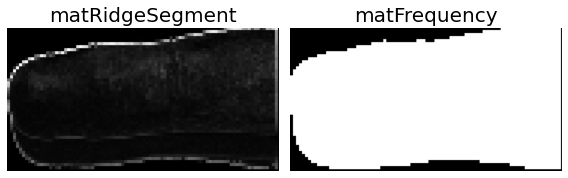

In [22]:
# display 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ax = axes.ravel()

ax[0].imshow(matRidgeSegment, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('matRidgeSegment', fontsize=20)

ax[1].imshow(matFrequency, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('matFrequency', fontsize=20)


fig.tight_layout()
plt.show()

In [23]:
def matCos(source):
    rows,cols = source.shape

    result =  np.zeros((cols, rows), np.float32)
    for  r in range( 0,  rows):
        for  c in range(0, cols):
            result[r, c]= math.cos(source[r, c])
        
    return result
    


def meshGrid(size) :
    l = (size * 2) + 1
    value = -size
    result =  np.zeros((l, l), np.float32)

    for c in range(0,l) :
        for  r in range (0,l):
            result[r, c]= value
        
        value=value+1
        
    return result
    

In [24]:
# step 4: get ridge filter
matRidgeFilter = np.zeros((imgRows, imgCols), np.float32)
filterSize = 1.9
# return padding
# matRidgeSegment, matRidgeOrientation, matFrequency, matRidgeFilter, filterSize, filterSize, medianFreq
# ridgeSegment, orientation, frequency, result,  kx, ky,  medianFreq
ridgeSegment=matRidgeSegment
orientation= matRidgeOrientation
frequency=matFrequency
result= matRidgeFilter
kx=filterSize
ky= filterSize
medianFreq=medianFreq

#  Enhance fingerprint image using oriented filters.
angleInc = 3
rows,cols = ridgeSegment.shape
filterCount = int(180 / angleInc)
filters = []
sigmaX = kx / medianFreq
sigmaY = ky / medianFreq


# mat refFilter = exp(-(x. ^ 2 / sigmaX ^ 2 + y. ^ 2 / sigmaY ^ 2) / 2). * cos(2 * pi * medianFreq * x);
size = int(round(3 * max(sigmaX, sigmaY)))
size =size if (size % 2 == 0)  else size + 1
length = (size * 2) + 1
x = meshGrid(size)
y = x.transpose()

xSquared=cv2.multiply(x, x)
ySquared=cv2.multiply(y, y)
xSquared=cv2.divide(xSquared, (sigmaX * sigmaX,0,0,0))
ySquared=cv2.divide(ySquared, (sigmaY * sigmaY,0,0,0))


refFilterPart1=cv2.add(xSquared, ySquared)
refFilterPart1=cv2.divide(refFilterPart1,(-2.0,0,0,0))
refFilterPart1= cv2.exp(refFilterPart1)


refFilterPart2= cv2.multiply(x, (2 * math.pi * medianFreq,0,0,0))
refFilterPart2 = matCos(refFilterPart2)

refFilter=cv2.multiply(refFilterPart1, refFilterPart2)

#Generate rotated versions of the filter.  Note orientation
# image provides orientation *along* the ridges, hence +90
# degrees, and the function requires angles +ve anticlockwise, hence the minus sign.

center = (length / 2, length / 2)
rotatedSize = (length, length)
rotateScale = 1.0

for i in range(0, filterCount):
    rotateAngle = -(i * angleInc)
    rotateMatrix = cv2.getRotationMatrix2D(center, rotateAngle, rotateScale)
    rotated=cv2.warpAffine(refFilter, rotateMatrix, rotatedSize, cv2.INTER_LINEAR)
    #filters[i] = rotated
    filters.append(rotated)
    

#convert orientation matrix values from radians to an index value
# that corresponds to round(degrees/angleInc)
orientIndexes=cv2.multiply(orientation, (float(filterCount) / math.pi,0,0,0), 1.0)

orientThreshold = np.zeros((orientation.shape[0], orientation.shape[1]), np.uint8)
orientThreshold[:]=0

orientIndexes=orientIndexes.astype(np.uint8)
print('orientIndexes',orientIndexes.shape,orientIndexes.dtype)
print('orientThreshold',orientThreshold.shape,orientThreshold.dtype)

orientMask= cv2.compare(orientIndexes, orientThreshold, cv2.CMP_LT)
orientIndexes=cv2.add(orientIndexes, (filterCount,0,0,0),  orientMask)

orientMask =  np.zeros((orientation.shape[0], orientation.shape[1]), np.uint8)
orientMask[:]=0
orientThreshold = np.zeros((orientation.shape[0], orientation.shape[1]), np.uint8)
orientThreshold[:]=filterCount


orientMask=cv2.compare(orientIndexes,orientThreshold, cv2.CMP_GE)
orientIndexes=cv2.subtract(orientIndexes, (filterCount,0,0,0), orientMask)

#finally, find where there is valid frequency data then do the filtering


for r in range(0,rows):
    for c in range (0 ,cols):
        if (frequency[r, c] > 0
                and r > (size + 1)
                and r < (rows - size - 1)
                and c > (size + 1)
                and c < (cols - size - 1)) :
            
            orientIndex = int(orientIndexes[r, c])
            subSegment = ridgeSegment[r - size - 1:r + size, c - size - 1: c + size]
            value=cv2.multiply(subSegment, filters[orientIndex])
            sum = cv2.sumElems(value)[0]
            result[r, c]= sum
        
    


# return size
padding=size

orientIndexes (1143, 2169) uint8
orientThreshold (1143, 2169) uint8


In [25]:
print('result : ',result.shape,result.dtype)
print('padding',padding)
print('result',np.unique(result))

result :  (1143, 2169) float32
padding 52
result [-374.27615 -373.98645 -373.62045 ...  469.08344  469.67264  470.1675 ]


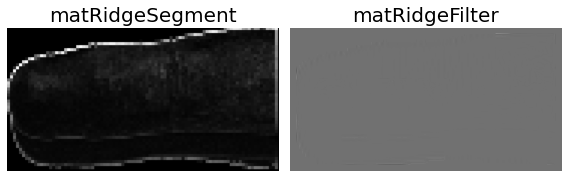

In [26]:
# display 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ax = axes.ravel()

ax[0].imshow(matRidgeSegment, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('matRidgeSegment', fontsize=20)

ax[1].imshow(matRidgeFilter, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('matRidgeFilter', fontsize=20)


fig.tight_layout()
plt.show()

In [38]:
def imagePadding(source, blockSize) :

        
        height,width = source.shape
       

        bottomPadding = 0
        rightPadding = 0

        if (width % blockSize != 0) :
            bottomPadding = blockSize - (width % blockSize)
        
        if (height % blockSize != 0) :
            rightPadding = blockSize - (height % blockSize)
            
        print('source: bottomPadding rightPadding', bottomPadding,rightPadding)
        
        # create a border around the image like a photo frame
        source = cv2.copyMakeBorder(source, 0, bottomPadding, 0, rightPadding, cv2.BORDER_CONSTANT, 0)
        
        return source
    



def snapShotMask(rows, cols, padding) :
        
    #Some magic numbers. We have no idea where these come from?!
       #int maskWidth = 260;
    #int maskHeight = 160;


    center = (int(cols / 2), int(rows / 2))
    axes = (int(cols / 2 - padding), int(rows / 2 - padding))
    scalarWhite = (255, 255, 255)
    scalarBlack = (0, 0, 0)
    thickness = -1
    lineType = 8

    mask = np.zeros((rows,cols), np.uint8) 
    mask[:]=0
    mask=cv2.ellipse(mask, center, axes, 0.0, 0.0, 360.0, scalarWhite, thickness, lineType, 0)
    
    return mask
    

In [39]:
paddingSize = padding

#step 5: enhance image after ridge filter
matEnhanced = np.zeros((imgRows, imgCols), np.uint8)
# matRidgeFilter, matEnhanced, blockSize, rows, cols, padding
# source, result, blockSize, rows, cols, padding
source=matRidgeFilter
result=matEnhanced
blockSize=blockSize
rows=rows
cols=cols
padding=padding

MatSnapShotMask = snapShotMask(rows, cols, padding)
if(MatSnapShotMask.shape!=source.shape):
    paddedMask = imagePadding(MatSnapShotMask, blockSize)
else:
    paddedMask=MatSnapShotMask
    
paddedMask=paddedMask.astype(np.float32)
print('MatSnapShotMask',MatSnapShotMask.shape,MatSnapShotMask.dtype)
print('paddedMask',paddedMask.shape,paddedMask.dtype)
print('source',source.shape,source.dtype)



# apply the original mask to get rid of extras
result= cv2.multiply(source, paddedMask)

# apply binary threshold
result= cv2.threshold(result, 0, 255, cv2.THRESH_BINARY)



MatSnapShotMask (1143, 2169) uint8
paddedMask (1143, 2169) float32
source (1143, 2169) float32


In [40]:
print('matEnhanced : ',matEnhanced.shape,matEnhanced.dtype)
print('matEnhanced',np.unique(matEnhanced))

matEnhanced :  (1143, 2169) uint8
matEnhanced [0]


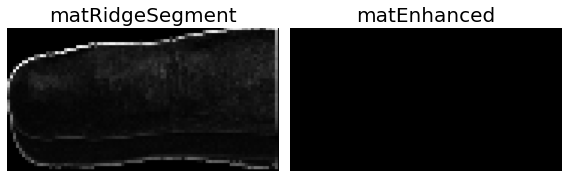

In [41]:
# display 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ax = axes.ravel()

ax[0].imshow(matRidgeSegment, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('matRidgeSegment', fontsize=20)

ax[1].imshow(matEnhanced, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('matEnhanced', fontsize=20)


fig.tight_layout()
plt.show()

In [ ]:
;
// oo
train_set, test_set = prepare_dataset(image_files) 

Checking the size of the training and test set. After the split of the dataset, there are 6 images per person (class) for train and 2 images for test. 
- train_set and test_set represent lists of tuples, with the form: (img_label, img)

In [ ]:
print('Size of the training set:', len(train_set))
print('Size of the test set:', len(test_set))

Next, we plot one image before and after converting it to grayscale and appling enhancement.

In [ ]:
plt.subplot(1, 2, 1)
plt.title('Before enhancement')
img_fpr = cv2.imread(image_files[0])
plt.imshow(img_fpr, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('After enhancement')
plt.imshow(train_set['10_i_1_w_1.jpg'], cmap='gray')
plt.show()

We define few methods used for the authetication scenarios.

ORB (Oriented FAST and Rotated BRIEF) descriptor is used to find matching keypoints. As a matching function we use number of matching features whose distance is below a given threshold.

In [ ]:
# Initiate ORB detector for matching keypoints
orb = cv2.ORB_create(MAX_FEATURES)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [ ]:
# Returns feature descripors for all images from the dataset
def get_feature_descriptors(dataset):
    feature_descriptors = {}
    for image_id, image in dataset.items():
        kp, des = orb.detectAndCompute(image, None)
        feature_descriptors[image_id] = des
    return feature_descriptors

In [ ]:
# Returns best_matches between training features descriptors and query image
def get_best_matches(query_image, trained_features, distance_threshold): 
    best_matches_dict = {}
    kp1, query_des = orb.detectAndCompute(query_image, None) # features of the query image
    for train_image_id, trained_feature_des in trained_features.items():
        if query_des is not None and trained_feature_des is not None:
            matches = bf.match(query_des, trained_feature_des)
            matches.sort(key=lambda x: x.distance, reverse=False) # sort matches based on feature distance
            
            best_matches = [m.distance for m in matches if m.distance < distance_threshold]
            best_matches_dict[train_image_id] = len(best_matches) # matching function = length of best matches to given threshold
    
    best_matches_dict = sorted(best_matches_dict.items(), key = operator.itemgetter(1), reverse=True) # sort by value - feature distance
    return best_matches_dict

In [ ]:
# Returns best_matches between training features descriptors and query image
def get_best_matches(query_image, trained_features, distance_threshold): 
    best_matches_dict = {}
    kp1, query_des = orb.detectAndCompute(query_image, None) # features of the query image
    for train_image_id, trained_feature_des in trained_features.items():
        if query_des is not None and trained_feature_des is not None:
            matches = bf.match(query_des, trained_feature_des)
            matches.sort(key=lambda x: x.distance, reverse=False) # sort matches based on feature distance
            
            best_matches = [m.distance for m in matches if m.distance < distance_threshold]
            best_matches_dict[train_image_id] = len(best_matches) # matching function = length of best matches to given threshold
    
    best_matches_dict = sorted(best_matches_dict.items(), key = operator.itemgetter(1), reverse=True) # sort by value - feature distance
    return best_matches_dict

In [ ]:
from collections import defaultdict

def classify_fpr(best_matches_dict, rank):
    '''
    Counts how many fprs from the same class are there in the first ranked 
    :param feature_distances: Feature distaces from given query fpr to all training fprs
    :param rank: To take the first ranked closest features
    :return first_rank_sorted: dictionary, where key denotes the fpr class and 
            the value is how many times it appears in the first ranked fprs
    '''
    first_rank_fprs = defaultdict(int)
    for fpr_name, distance in best_matches_dict[0:rank]:
        fpr_class = get_image_class(fpr_name)
        first_rank_fprs[fpr_class] += 1
            
    first_rank_sorted = sorted(first_rank_fprs.items(), key = operator.itemgetter(1), reverse=True) 
    return first_rank_sorted 

In [ ]:
def draw_keypoints_matches(fpr1, fpr2):
    kp1, des1 = orb.detectAndCompute(fpr1, None) 
    kp2, des2 = orb.detectAndCompute(fpr2, None)

    matches = bf.match(des1, des2)
    matches.sort(key=lambda x: x.distance, reverse=False)
    imMatches = cv2.drawMatches(fpr1, kp1, fpr2, kp2,matches[:10], None)

    plt.imshow(imMatches)
    plt.show()

## Authentication scenario

 we analyse the authentication scenario, which corresponds to 1:1 problem or binary classification. The question that is asked is: “Can you prove who you are?”. A system will challenge someone to prove their identity and the person has to respond in order to allow them access to a system or service. For example, a person touches their finger on a sensor embedded in a smartphone, used by the authentication solution as part of a challenge/response system. "Is it my finger? Yes, then my smartphone is unlocked, or No it isn’t my finger and the smartphone remains locked." [2]

For the authentication scenairo, the data structure for training is slightly different, whereas the test set remains the same. For the training set, the already computed features are divided in separate dictionaries (that act as databases) where the key denotes the class (person), and then every image features for the correspoding class are set in the dictionary as a value.

In [ ]:
train_feature_descriptors = get_feature_descriptors(train_set)
authentication_databases = prepare_dataset_authentication(train_feature_descriptors)

In [ ]:
print('Classes in the training set = {}'.format(authentication_databases.keys()))

In [ ]:
def count_same_fprs(feature_distances, len_best_matches):
    '''
    Counts how many fprs are close to the query fpr
    :param feature_distances: Feature distaces from given query fpr to all training fprs
    :param len_best_matches: Predefined value for the length of best features
    :return count_same: number of same fprs paris within the given len_best_matches
    '''
    count_same = 0
    for features in feature_distances:
        if int(features[1]) > len_best_matches: # Compare the len of best features for the given feature with the predefined len
            count_same += 1
            
    return count_same

In [ ]:
def perform_authentication_scenario(dist_threshold, len_best_matches):
    true_y = []
    pred_y = []
    total_distances = []
    print("----- START, Threshold = {} -----".format(dist_threshold))
    for authentication_db_key in authentication_databases.keys():
        authentication_db = authentication_databases[authentication_db_key]
        for test_image_id, test_image in test_set.items():    
            best_matches_dict = get_best_matches(test_image, authentication_db, dist_threshold)
            total_distances.append(best_matches_dict[0])
            
            count_same = count_same_fprs(best_matches_dict, len_best_matches)
            ratio = count_same/len(authentication_db.keys())
            test_image_class = get_image_class(test_image_id)
            true_class = 1 if test_image_class == authentication_db_key else 0
            true_y.append(true_class)
            
            if ratio >= 0.5: 
                pred_y.append(1)
            else:
                pred_y.append(0) 
    
    identical = true_y
    print("Accuracy is %f "%(round(accuracy_score(true_y, pred_y),4)))
    print('The precision score is {}'.format(precision_score(true_y, pred_y)))
    print('F1 score is {}'.format(round(f1_score(true_y, pred_y), 4)))

    return total_distances, identical

Before iterating through different thershold values and length of best matches, we show an example for authenticating one query fingerprint against all fprs databases.

In [ ]:
# Example 
test_image_id = list(test_set)[0]
authentication_db = authentication_databases['10i1w']
best_matches_dict = get_best_matches(test_set[test_image_id], authentication_db , 50) 
count_same = count_same_fprs(best_matches_dict, 10)
ratio = count_same/len(authentication_db.keys())
print('--- For query image: {} ---'.format(test_image_id))
print('Probability of correct fpr for class 10i1w = {}'.format(round(ratio,4)))
draw_keypoints_matches(test_set[test_image_id], train_set['10_i_1_w_1.jpg'])

We can notice that there are ~ 100% chances that the person will be correctly authenticated.

In [ ]:
len_best_matches = 15
for dist_threshold in range(30, 70, 10): 
    perform_authentication_scenario(dist_threshold, len_best_matches)

Highest accuracy score = 0.93 and precision score = 0.6, F1 score = 0.72, are obtained with distance threshold = 50.

In [ ]:
distances, identical = perform_authentication_scenario(50, len_best_matches)
genuine_scores, impostor_scores = get_genuine_impostor_scores(distances, identical) 

[PyEER](https://github.com/manuelaguadomtz/pyeer) is a Python package intended for biometric systems performance evaluation. This package is used for computing the EER, as well as the FAR and FRR later.

EER represents a point where both FAR and FRR are equal.

In [ ]:
stats = get_eer_stats(genuine_scores, impostor_scores)
generate_eer_report([stats], ['A'], 'pyeer_report.csv')

In [ ]:
eer = round(stats.eer, 4)
print('Equal Error Rate is: {}'.format(eer))

The evaluation of 1:1 biometric authentication systems is usually done by estimating False Accept Rate (FAR) and False Reject Rate (FRR). Using these estimates, a ROC curve is generated. [1] Compared to the standard ROC curve, where we plot the True Positive Rate (TPR) against the False Positive Rate (FAR), in the domain of biometric sytems, instead of TPR, we plot FRR (or 1 - TPR).

### ROC curve  (FAR vs FRR)

In [ ]:
print('Generating ROC curve: False accept rates vs. false reject rates')
get_roc_curve(stats.fnmr, stats.fmr)

## References:

[1] R. M. Bolle, J. H. Connell, S. Pankanti, N. K. Ratha and A. W. Senior, "The relation between the ROC curve and the CMC," Fourth IEEE Workshop on Automatic Identification Advanced Technologies (AutoID'05), Buffalo, NY, USA, 2005, pp. 15-20.

[2] "Biometric Identification or Biometric Authentication?" Alan Goode, Retrieved from: https://www.veridiumid.com/blog